In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# Upload your files manually in Google Colab
from google.colab import files
uploaded = files.upload()



Saving books.csv to books.csv


In [4]:
uploaded2 = files.upload()

Saving ratings.csv to ratings.csv


In [5]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)
df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [6]:
books = pd.read_csv("books.csv")
ratings = pd.read_csv("ratings.csv")


In [7]:
merged = ratings.merge(books, left_on="book_id", right_on="book_id")

In [8]:
merged["label"] = (merged["rating"] >= 4).astype(int)

features = merged[["average_rating", "work_ratings_count", "label"]].dropna()

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(features[["average_rating", "work_ratings_count"]])
y = features["label"].values.reshape(-1, 1)


In [10]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [12]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

model = MLP()

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.6488
Epoch 20, Loss: 0.6466
Epoch 30, Loss: 0.6448
Epoch 40, Loss: 0.6434
Epoch 50, Loss: 0.6422


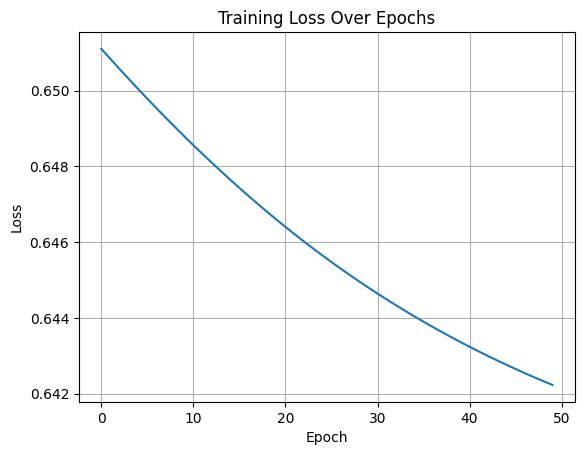

In [14]:
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [15]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predicted_labels = (predictions >= 0.5).float().numpy()
    y_true = y_test.numpy()

In [16]:
accuracy = accuracy_score(y_true, predicted_labels)
precision = precision_score(y_true, predicted_labels)
recall = recall_score(y_true, predicted_labels)
f1 = f1_score(y_true, predicted_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.6651
Precision: 0.6651
Recall:    1.0000
F1 Score:  0.7989


In [24]:

new_data = pd.DataFrame({
    "average_rating": [4.5, 3.0, 4.8],
    "work_ratings_count": [1000000, 50000, 5000000]
})

X_new = scaler.transform(new_data[["average_rating", "work_ratings_count"]])
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)

model.eval() # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_new_tensor)
    predicted_labels = (predictions >= 0.72).float().numpy()
print("Predictions (0: Not finished, 1: Finished):")
print(predicted_labels)

Predictions (0: Not finished, 1: Finished):
[[1.]
 [0.]
 [1.]]
